In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib
#import seaborn as sns
import re
from datetime import datetime

#style.use('fivethirtyeight')
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline

In [2]:
df_napic_master = pd.read_pickle('../notebooks/df_napic-14-3-2018') # for large files
df_napic_master.head()

ALAMAT  B_TINGKAT           DAERAH1  HARGA_B  \
15         NO. 296,LRG. BERINGIN 6      2.000             Kulim     1000   
43         9,LALUAN SRI KLEBANG 26      2.000             Kinta     1000   
80                NO. 150-H,JLN 33      1.000             Klang     1000   
111                       5,JLN 23      1.000            Kluang     1000   
114  LOT 7867,JLN LAPANGAN TERBANG      2.000  Bahagian Kuching     1000   

                    JENIS_HAKMILIK          JENIS_LOT KLASIFIKASI_KAW  \
15                          Hs (D)               P.T.             NaN   
43                          Hs (D)               P.T.             NaN   
80   Certificate Document Of Title  Hakmilik Muktamad             NaN   
111                         Hs (D)        No. Jabatan             NaN   
114                      Lain-Lain          Lain-Lain             NaN   

     LOT_PLOT  LUAS_LOT  LUAS_LOT_BGN                  MUKIM1  \
15       2091   250.000       121.000                   Kulim   
43     186670   153.000       164.000               Ulu Kinta   
80         16   563.000       149.000  Pekan Pelabuhan Kelang   
111  PTD 4590    97.000        52.000                   Paloh   
114  B16/7867   582.000       187.000                     NaN   

            NO_HAKMILIK PM_PERTAMA                        PRO_TYPE  \
15              1238/92          T       2 - 2 1/2 Storey Terraced   
43               123679          T       2 - 2 1/2 Storey Terraced   
80                24487          T                        Detached   
111                9946          T                  Low-Cost House   
114  13/01/093/016/7867          T  2 - 2 1/2 Storey Semi-Detached   

          SECTOR                     SKIM     STATE  STAT_FEREE  STAT_FEROR  \
15   Residential             TMN BERINGIN     Kedah           2           2   
43   Residential  BANDAR BARU SRI KLEBANG     Perak           2           2   
80   Residential          PELABUHAN KLANG  Selangor           2           2   
111  Residential         TAMAN KOTA PALOH     Johor           2           2   
114  Residential            GREEN HEIGHTS   Sarawak           2           2   

     SYER1  SYER2  TKH_NILAI                    TRANSEFEROR  \
15   1.000  3.000 2005-12-15                     M MUNIANDY   
43   1.000  2.000 2005-09-26                  NEO YOKE CHOO   
80   1.000  1.000 1998-02-23      PADMAVATHI I/K SRINIVASAN   
111  1.000  1.000 2006-03-14  PARMASIVAM A/L GOPALAKRISHNAN   
114  1.000  2.000 2006-09-19         LIAU KEE SUT @ THERESA   

                    TRANSFEREE      year  month    day  quarter year_month  \
15                   M NIRMALA 2,005.000 12.000 15.000    4.000    2005-12   
43                 TEH SIN YEW 2,005.000  9.000 26.000    3.000    2005-09   
80   VARADARAJU A/L SRINIVASAN 1,998.000  2.000 23.000    1.000    1998-02   
111   RAJAN A/L GOPALAKRISHNAN 2,006.000  3.000 14.000    1.000    2006-03   
114              POH KIM KWANG 2,006.000  9.000 19.000    3.000    2006-09   

     Price_per_sqrft  Price_per_sqrft_lot  Price_per_sqrft_min  
15             8.264                4.000                4.000  
43             6.098                6.536                6.098  
80             6.711                1.776                1.776  
111           19.231               10.309               10.309  
114            5.348                1.718                1.718

In [3]:
# Load NAPIC

df_napic_master = pd.read_pickle('../notebooks/df_napic-14-3-2018')
df_napic_master["year_month"] = df_napic_master.TKH_NILAI.dt.to_period('M')

# Too many missing values
df_napic_master.drop('KLASIFIKASI_KAW', inplace=True, axis=1)
# for c in df_napic_master.columns:
#     if df_napic_master[c].dtype == 'object':
#         df_napic_master = df_napic_master[df_napic_master[c].notnull()].copy()
# filter out size using the same rule as BIS. Ref: https://www.bis.org/ifc/publ/ifcb44i.pdf
df_napic_master= df_napic_master[(df_napic_master['LUAS_LOT_BGN'] > 21) & (df_napic_master['LUAS_LOT_BGN'] < 10000)].copy()
df_napic_master= df_napic_master[(df_napic_master['LUAS_LOT'] > 21) & (df_napic_master['LUAS_LOT'] < 10000)].copy()

In [4]:
df_napic_master = df_napic_master[df_napic_master['year'] > 2012].copy()

In [5]:
df_napic_master['quarter'] = ((df_napic_master['month']-1)//3+1)
df_napic_master['year-quarter'] = df_napic_master['year'].astype(int).astype(str) + '-' + df_napic_master['quarter'].astype(int).astype(str)

In [6]:
df_napic_master['PRO_TYPE'].unique()

array(['2 - 2 1/2 Storey Terraced', '1 - 1 1/2 Storey Terraced',
       'Low-Cost House', 'Detached', 'Condominium/Apartment',
       'Cluster House', 'Flat', 'Low-Cost Flat',
       '1 - 1 1/2 Storey Semi-Detached', '2 - 2 1/2 Storey Semi-Detached',
       'Town House', 'Others'], dtype=object)

In [7]:
prop_type_dict = {
    '1 - 1 1/2 Storey Semi-Detached' : 'Semi-D' ,
    '1 - 1 1/2 Storey Terraced' : 'Terrace',
    '2 - 2 1/2 Storey Semi-Detached' : "Semi-D", 
    '2 - 2 1/2 Storey Terraced' : 'Terrace',
    'Condominium/Apartment' : 'Condo/Apt',
    'Detached' : "Detached", 
    'Flat' : "Flat",
    'Low-Cost Flat' : "Flat"
}

In [8]:
df_napic_master2 = df_napic_master.copy()
df_napic_master2['Property_Group'] = df_napic_master2["PRO_TYPE"].map(prop_type_dict).copy()

In [9]:
pwd

'C:\\Users\\sstan\\Desktop\\notebooks'

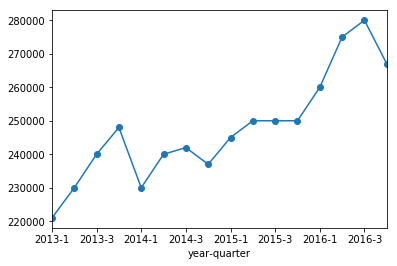

In [10]:
overall_df_napic_master2 = df_napic_master2.groupby('year-quarter').median()['HARGA_B']
#export to excel
overall_df_napic_master2.to_excel('../data/excel/NAPIC_pricebyquarter_median.xlsx')
#plot
overall_df_napic_master2.plot(marker='o')

         low   mid  high
2013-1 0.645 0.249 0.106
2013-2 0.627 0.255 0.118
2013-3 0.620 0.265 0.115
2013-4 0.603 0.276 0.122
2014-1 0.638 0.261 0.101


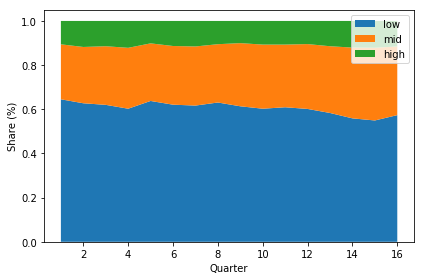

In [11]:
bins = [0, 300000, 650000]
df_napic_master2['price_bins'] =  np.searchsorted(bins, df_napic_master2['HARGA_B'].values)

df_PricebinBreakdown = pd.DataFrame()
for year in sorted(df_napic_master2['year-quarter'].unique()):
    df_thatYear = df_napic_master2[df_napic_master2['year-quarter'] == year]
    df_PricebinBreakdown = df_PricebinBreakdown.append(df_thatYear['price_bins'].value_counts(1))

renamed_col = ['low','mid','high']
df_PricebinBreakdown.columns = renamed_col
df_PricebinBreakdown.index = sorted(df_napic_master2['year-quarter'].unique())
print(df_PricebinBreakdown.head())

#export to excel
df_PricebinBreakdown.to_excel('../data/excel/NAPIC_pricebinbreakdown.xlsx')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.stackplot([i for i in range(1,17)],df_PricebinBreakdown['low'],df_PricebinBreakdown['mid'],df_PricebinBreakdown['high'])
plt.xlabel("Quarter")
plt.ylabel("Share (%)")
plt.legend(['low','mid','high'])
plt.tight_layout()


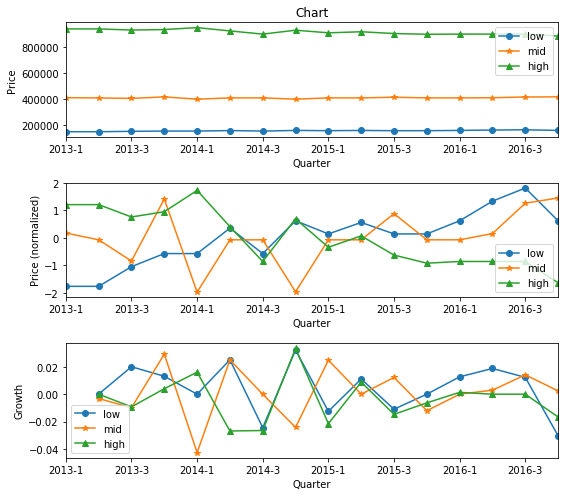

In [12]:
low_end_df_napic_master2 = df_napic_master2[df_napic_master2['price_bins'] == 1].groupby('year-quarter').median()['HARGA_B']
mid_end_df_napic_master2 = df_napic_master2[df_napic_master2['price_bins'] == 2].groupby('year-quarter').median()['HARGA_B']
high_end_df_napic_master2 = df_napic_master2[df_napic_master2['price_bins'] == 3].groupby('year-quarter').median()['HARGA_B']
X_scaled = (low_end_df_napic_master2 - low_end_df_napic_master2.mean())/low_end_df_napic_master2.std()
Y_scaled = (mid_end_df_napic_master2 - mid_end_df_napic_master2.mean())/mid_end_df_napic_master2.std()
Z_scaled = (high_end_df_napic_master2 - high_end_df_napic_master2.mean())/high_end_df_napic_master2.std()

#export to excel
low_end_df_napic_master2.to_excel('../data/excel/NAPIC_LowEndPrice.xlsx')
mid_end_df_napic_master2.to_excel('../data/excel/NAPIC_MidEndPrice.xlsx')
high_end_df_napic_master2.to_excel('../data/excel/NAPIC_HighEndPrice.xlsx')

plt.figure(figsize=(8,7))
plt.subplot(3, 1, 1)
low_end_df_napic_master2.plot(marker='o')
mid_end_df_napic_master2.plot(marker='*')
high_end_df_napic_master2.plot(marker='^')

plt.title("Chart")
plt.ylabel("Price")
plt.xlabel("Quarter")
plt.legend(['low','mid','high'])

plt.subplot(3, 1, 2)
X_scaled.plot(marker='o')
Y_scaled.plot(marker='*')
Z_scaled.plot(marker='^')

plt.ylabel("Price (normalized)")
plt.xlabel("Quarter")
plt.legend(['low','mid','high'])

plt.subplot(3, 1, 3)
low_end_df_napic_master2.pct_change().plot(marker='o')
mid_end_df_napic_master2.pct_change().plot(marker='*')
high_end_df_napic_master2.pct_change().plot(marker='^')

plt.ylabel("Growth")
plt.xlabel("Quarter")
plt.legend(['low','mid','high'])
plt.tight_layout()
#df_PricebinBreakdown.to_excel('../Napic-DistributionCondo.xlsx')

Text(0.5,1,'Napic - Flat/Condominium')

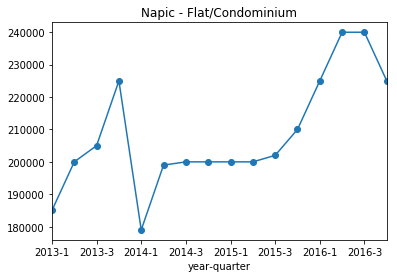

In [13]:
df_napic_master2_condo = df_napic_master2[df_napic_master2['Property_Group'].isin(['Flat','Condo/Apt'])].copy()
overall_df_napic_master2_condo = df_napic_master2_condo.groupby('year-quarter').median()['HARGA_B']

#export to excel
overall_df_napic_master2_condo.to_excel('../data/excel/NAPIC_PricebyQuarterCondo_Median.xlsx')

# plot
overall_df_napic_master2_condo.plot(marker='o')
plt.title("Napic - Flat/Condominium")

         low   mid  high
2013-1 0.683 0.227 0.090
2013-2 0.650 0.251 0.099
2013-3 0.643 0.266 0.091
2013-4 0.616 0.273 0.111
2014-1 0.707 0.220 0.073


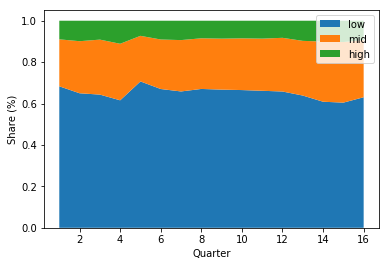

In [14]:
df_CondoPricebinBreakdown = pd.DataFrame()
#renamed_col = []
for year in sorted(df_napic_master2_condo['year-quarter'].unique()):
    df_thatYear = df_napic_master2_condo[df_napic_master2_condo['year-quarter'] == year]
    df_CondoPricebinBreakdown = df_CondoPricebinBreakdown.append(df_thatYear['price_bins'].value_counts(1))
    #df_CondoPricebinBreakdown = df_CondoPricebinBreakdown.append(df_thatYear['price_bins'].value_counts())
    #df_CondoPricebinBreakdown = df_CondoPricebinBreakdown.append(df_thatYear['price_bins'].value_counts(1))
    #for col_name in ['count', percentage']:
    #    renamed_col.append('{}-{}'.format(col_name, year))

renamed_col = ['low','mid','high']
df_CondoPricebinBreakdown.columns = renamed_col
df_CondoPricebinBreakdown.index = sorted(df_napic_master2['year-quarter'].unique())
print(df_CondoPricebinBreakdown.head())


#export to excel
df_CondoPricebinBreakdown.to_excel('../data/excel/NAPIC_PriceBinCondoBreakdown.xlsx')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.stackplot([i for i in range(1,17)],df_CondoPricebinBreakdown['low'],df_CondoPricebinBreakdown['mid'],df_CondoPricebinBreakdown['high'])
plt.xlabel("Quarter")
plt.ylabel("Share (%)")
plt.legend(['low','mid','high'])

In [15]:
# rename column
#temp = sorted(df_napic_master2['year-quarter'].unique())
#df_CondoPricebinBreakdown = df_CondoPricebinBreakdown[['percentage-' + i for i in temp]]

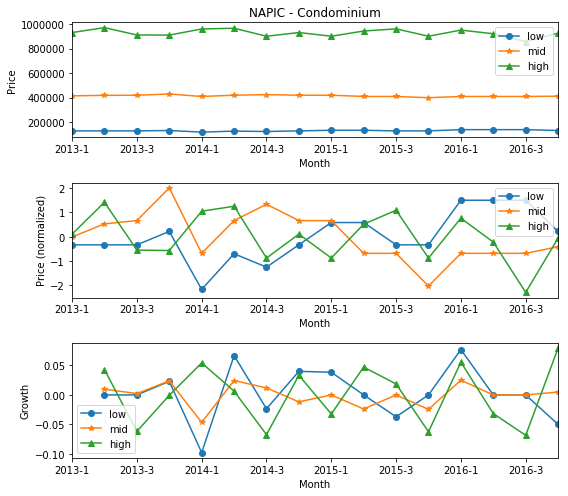

In [16]:
bins = [0, 300000, 650000]
# bins= [0, 500000]
df_napic_master2_condo['price_bins'] =  np.searchsorted(bins, df_napic_master2_condo['HARGA_B'].values)
df_napic_master2_condo

df_CondoPricebinBreakdown = pd.DataFrame() # empty dataframe
df_CondoPricebinBreakdown =df_CondoPricebinBreakdown.append(df_napic_master2_condo['price_bins'].value_counts())
df_CondoPricebinBreakdown= df_CondoPricebinBreakdown.append(df_napic_master2_condo['price_bins'].value_counts(1)) # return percentages
df_CondoPricebinBreakdown=df_CondoPricebinBreakdown.transpose()

df_CondoPricebinBreakdown.columns=['count', 'percentage'] # rename columns
df_CondoPricebinBreakdown

low_end_df_napic_master2_condo = df_napic_master2_condo[df_napic_master2_condo['price_bins'] == 1].groupby('year-quarter').median()['HARGA_B']
mid_end_df_napic_master2_condo = df_napic_master2_condo[df_napic_master2_condo['price_bins'] == 2].groupby('year-quarter').median()['HARGA_B']
high_end_df_napic_master2_condo = df_napic_master2_condo[df_napic_master2_condo['price_bins'] == 3].groupby('year-quarter').median()['HARGA_B']
X_scaled = (low_end_df_napic_master2_condo - low_end_df_napic_master2_condo.mean())/low_end_df_napic_master2_condo.std()
Y_scaled = (mid_end_df_napic_master2_condo - mid_end_df_napic_master2_condo.mean())/mid_end_df_napic_master2_condo.std()
Z_scaled = (high_end_df_napic_master2_condo - high_end_df_napic_master2_condo.mean())/high_end_df_napic_master2_condo.std()

#export to excel
low_end_df_napic_master2_condo.to_excel('../data/excel/NAPIC_LowEndCondoPrice.xlsx')
mid_end_df_napic_master2_condo.to_excel('../data/excel/NAPIC_MidEndCondoPrice.xlsx')
high_end_df_napic_master2_condo.to_excel('../data/excel/NAPIC_HighCondoEndPrice.xlsx')


plt.figure(figsize=(8,7))
plt.subplot(3, 1, 1)
low_end_df_napic_master2_condo.plot(marker='o')
mid_end_df_napic_master2_condo.plot(marker='*')
high_end_df_napic_master2_condo.plot(marker='^')

plt.title("NAPIC - Condominium")
plt.ylabel("Price")
plt.xlabel("Month")
plt.legend(['low','mid','high'])

plt.subplot(3, 1, 2)
X_scaled.plot(marker='o')
Y_scaled.plot(marker='*')
Z_scaled.plot(marker='^')

plt.ylabel("Price (normalized)")
plt.xlabel("Month")
plt.legend(['low','mid','high'])

plt.subplot(3, 1, 3)
low_end_df_napic_master2_condo.pct_change().plot(marker='o')
mid_end_df_napic_master2_condo.pct_change().plot(marker='*')
high_end_df_napic_master2_condo.pct_change().plot(marker='^')

plt.ylabel("Growth")
plt.xlabel("Month")
plt.legend(['low','mid','high'])

plt.tight_layout()

In [17]:
# Load Propwall
df_sales = pd.read_csv('../notebooks/Propwall_Report_ForSale-28-3-18.csv')

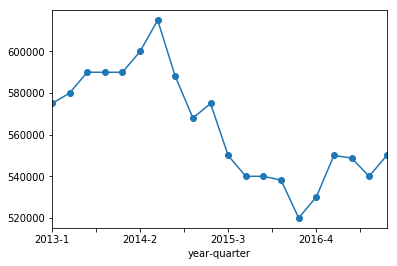

In [18]:
df_sales['quarter'] = ((df_sales['month'] - 1)//3 + 1)
df_sales['year-quarter'] = df_sales['year'].astype(str) + '-' + df_sales['quarter'].astype(str)
overall_df_sales = df_sales.groupby('year-quarter').median()['price']
#export to excel
overall_df_sales.to_excel('../data/excel/SP_PriceByQuarter_Median.xlsx')
#plot
overall_df_sales.plot(marker='o')

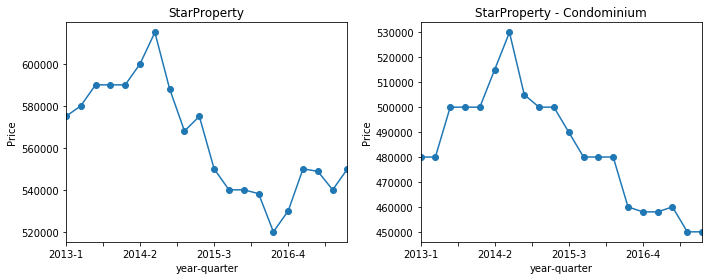

In [19]:
df_sales_condo = df_sales[df_sales['Type'] == 'Condominium'].copy()
overall_df_sales_condo = df_sales.groupby('year-quarter').median()['price']
#export to excel
overall_df_sales.to_excel('../data/excel/SP_PriceByQuarterCondo_Median.xlsx')


plt.figure(figsize=(10,4))

ax1 = plt.subplot(1, 2, 1)
overall_df_sales = df_sales.groupby('year-quarter').median()['price']
overall_df_sales.plot(marker='o')
plt.title("StarProperty")
plt.ylabel("Price")

ax2 = plt.subplot(1, 2, 2)
overall_df_sales_condo = df_sales_condo.groupby('year-quarter').median()['price']
overall_df_sales_condo.plot(marker='o')
plt.title("StarProperty - Condominium")
plt.ylabel("Price")

plt.tight_layout()

         low   mid  high
2013-1 0.116 0.647 0.236
2013-2 0.109 0.643 0.249
2013-3 0.094 0.635 0.271
2013-4 0.113 0.617 0.270
2014-1 0.096 0.627 0.278


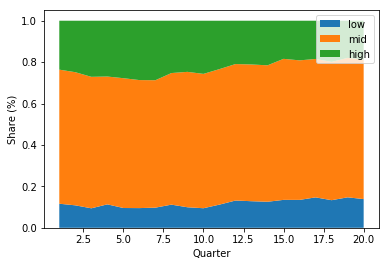

In [20]:
bins = [0, 300000, 650000]
df_sales_condo['price_bins'] =  np.searchsorted(bins, df_sales_condo['price'].values)
df_salesCondoPricebinBreakdown = pd.DataFrame()
#renamed_col = []
for year in sorted(df_sales_condo['year-quarter'].unique()):
    df_thatYear = df_sales_condo[df_sales_condo['year-quarter'] == year]
    df_salesCondoPricebinBreakdown = df_salesCondoPricebinBreakdown.append(df_thatYear['price_bins'].value_counts(1))

renamed_col = ['low','mid','high']
df_salesCondoPricebinBreakdown.columns = renamed_col
df_salesCondoPricebinBreakdown.index = sorted(df_sales_condo['year-quarter'].unique())
print(df_salesCondoPricebinBreakdown.head())

#export to excel
df_salesCondoPricebinBreakdown.to_excel('../data/excel/SP_PriceBinCondoBreakdown.xlsx')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.stackplot([i for i in range(1,21)],df_salesCondoPricebinBreakdown['low'],df_salesCondoPricebinBreakdown['mid'],df_salesCondoPricebinBreakdown['high'])
plt.xlabel("Quarter")
plt.ylabel("Share (%)")
plt.legend(['low','mid','high'])

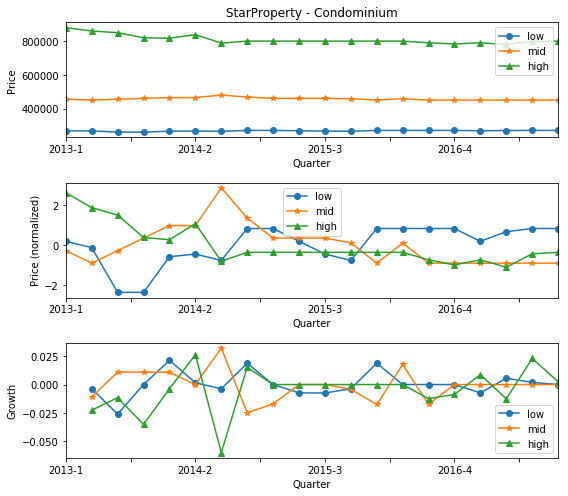

In [21]:
low_end_df_sales_condo = df_sales_condo[df_sales_condo['price_bins'] == 1].groupby('year-quarter').median()['price']
mid_end_df_sales_condo = df_sales_condo[df_sales_condo['price_bins'] == 2].groupby('year-quarter').median()['price']
high_end_df_sales_condo = df_sales_condo[df_sales_condo['price_bins'] == 3].groupby('year-quarter').median()['price']
X_scaled = (low_end_df_sales_condo - low_end_df_sales_condo.mean())/low_end_df_sales_condo.std()
Y_scaled = (mid_end_df_sales_condo - mid_end_df_sales_condo.mean())/mid_end_df_sales_condo.std()
Z_scaled = (high_end_df_sales_condo - high_end_df_sales_condo.mean())/high_end_df_sales_condo.std()

#export to excel
low_end_df_napic_master2_condo.to_excel('../data/excel/SP_LowEndCondoPrice.xlsx')
mid_end_df_napic_master2_condo.to_excel('../data/excel/SP_MidEndCondoPrice.xlsx')
high_end_df_napic_master2_condo.to_excel('../data/excel/SP_HighCondoEndPrice.xlsx')

plt.figure(figsize=(8,7))
plt.subplot(3, 1, 1)
low_end_df_sales_condo.plot(marker='o')
mid_end_df_sales_condo.plot(marker='*')
high_end_df_sales_condo.plot(marker='^')

plt.title("StarProperty - Condominium")
plt.ylabel("Price")
plt.xlabel("Quarter")
plt.legend(['low','mid','high'])

plt.subplot(3, 1, 2)
X_scaled.plot(marker='o')
Y_scaled.plot(marker='*')
Z_scaled.plot(marker='^')

plt.ylabel("Price (normalized)")
plt.xlabel("Quarter")
plt.legend(['low','mid','high'])

plt.subplot(3, 1, 3)
low_end_df_sales_condo.pct_change().plot(marker='o')
mid_end_df_sales_condo.pct_change().plot(marker='*')
high_end_df_sales_condo.pct_change().plot(marker='^')

plt.ylabel("Growth")
plt.xlabel("Quarter")
plt.legend(['low','mid','high'])

plt.tight_layout()

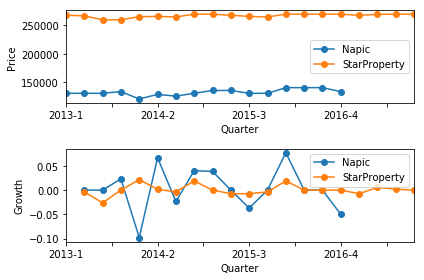

In [22]:
plt.subplot(2, 1, 1)
low_end_df_napic_master2_condo.plot(marker='o')
low_end_df_sales_condo.plot(marker='o')
plt.ylabel("Price")
plt.xlabel("Quarter")
plt.legend(['Napic','StarProperty'])

plt.subplot(2, 1, 2)
low_end_df_napic_master2_condo.pct_change().plot(marker='o')
low_end_df_sales_condo.pct_change().plot(marker='o')
plt.ylabel("Growth")
plt.xlabel("Quarter")
plt.legend(['Napic','StarProperty'])

plt.tight_layout()

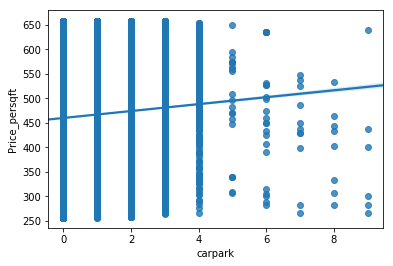

In [23]:
import seaborn as sns
sns.regplot(x="carpark", y="Price_persqft", data=df_sales_condo)
plt.show()

In [24]:
df_sales_condo.head()

Unnamed: 0         Type                      Location  \
0           0  Condominium                           NaN   
3          22  Condominium                           NaN   
4          33  Condominium  Ara Damansara, Petaling Jaya   
5          37  Condominium        Tanjung Tokong, Penang   
6          49  Condominium            TTDI, Kuala Lumpur   

                    Property       price  size     layout      furnishing  \
0  Seremban, Negeri Sembilan 900,000.000  1550  5-Bedroom  Semi-Furnished   
3          Batu Pahat, Johor 365,000.000  1091  3-Bedroom     Unfurnished   
4                        NaN 600,000.000  1600  4-Bedroom  Semi-Furnished   
5                        NaN 600,000.000  1600  4-Bedroom  Semi-Furnished   
6                        NaN 430,000.000   893  3-Bedroom  Semi-Furnished   

   bath  carpark         posting_date             Location_property  \
0 0.000        0  2015-10-20 16:40:41     Seremban, Negeri Sembilan   
3 2.000        0  2017-12-14 00:55:08             Batu Pahat, Johor   
4 2.000        2  2017-12-14 01:47:17  Ara Damansara, Petaling Jaya   
5 2.000        2  2017-12-14 01:55:06        Tanjung Tokong, Penang   
6 2.000        0  2017-12-14 09:31:48            TTDI, Kuala Lumpur   

             State  num_bedroom        date  year  month year_month  \
0  Negeri Sembilan            5  2015-10-20  2015     10    2015-10   
3            Johor            3  2017-12-14  2017     12    2017-12   
4    Petaling Jaya            4  2017-12-14  2017     12    2017-12   
5           Penang            4  2017-12-14  2017     12    2017-12   
6     Kuala Lumpur            3  2017-12-14  2017     12    2017-12   

   Price_persqft  quarter year-quarter  price_bins  
0        580.645        4       2015-4           3  
3        334.555        4       2017-4           2  
4        375.000        4       2017-4           2  
5        375.000        4       2017-4           2  
6        481.523        4       2017-4           2

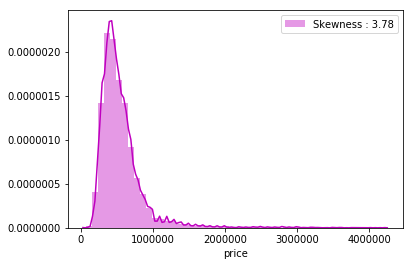

In [25]:
price_dist = sns.distplot(df_sales_condo["price"], color="m", label="Skewness : %.2f"%(df_sales_condo["price"].skew()))
price_dist = price_dist.legend(loc="best")
plt.show()